# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 06.12.2021

Мягкий дедлайн: 18.12.2021 23:59 MSK

Жёсткий дедлайн: 19.12.2021 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [82]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score



sns.set(style='darkgrid')
filterwarnings('ignore')

In [14]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [51]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 16.8 s, sys: 103 ms, total: 16.9 s
Wall time: 16.9 s
Train ROC-AUC 0.9934
Valid ROC-AUC 0.9307
Test ROC-AUC 0.9331


## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

  0%|          | 0/15 [00:00<?, ?it/s]

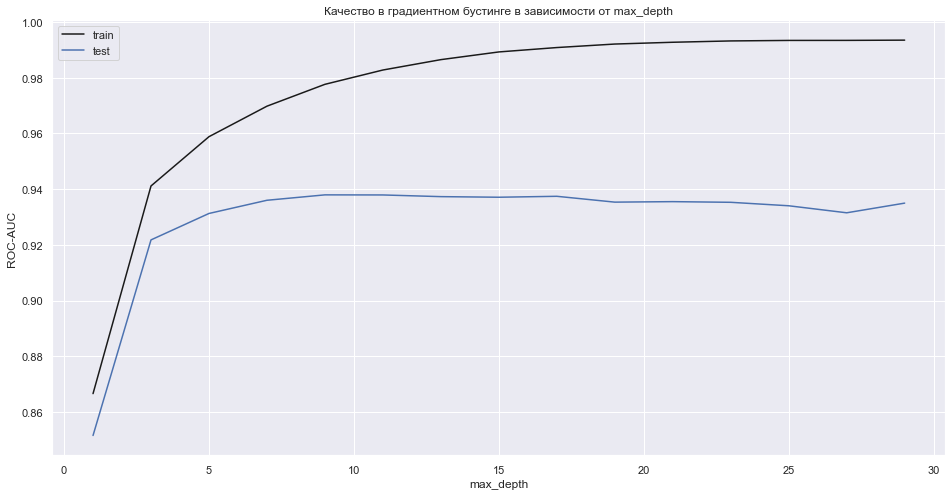

In [50]:
results = {'train': [], 'test': []}

depths = range(1, 30, 2)

for depth in tqdm(depths):
    boosting = Boosting(base_model_params={'max_depth': depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)

    results['train'].append(boosting.score(x_train, y_train))
    results['test'].append(boosting.score(x_test, y_test))

plt.figure(figsize=(16, 8))

plt.plot(depths, results['train'], label='train', c='k')
plt.plot(depths, results['test'], label='test', c='b')

plt.title('Качество в градиентном бустинге в зависимости от max_depth')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')

plt.legend()
plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Чем выше глубина, тем лучше становится качество, но в определенный момент оно перестает рости из-за переобучения. На обучающей выборке выборке качество растет всегда, хотя на тестовой нет.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

In [70]:
def choose_boosting(
        x_train, y_train,
        x_valid, y_valid,
        name, start, end, ran,
        is_base_model_param=False,
):
    results = {'train': [], 'valid': []}

    for param in np.arange(start, end, ran):
        arguments = {name: param}
        boosting = Boosting(**arguments)
        boosting.fit(x_train, y_train, x_valid, y_valid)
        results['train'].append(boosting.score(x_train, y_train))
        results['valid'].append(boosting.score(x_valid, y_valid))


    plt.plot(np.arange(start, end, ran), results['train'], label='train', c='k')
    plt.plot(np.arange(start, end, ran), results['valid'], label='valid', c='b')

    plt.title('Качество в градиентном бустинге')
    plt.xlabel(name)
    plt.ylabel('ROC-AUC')

    plt.legend()

    best_param = np.arange(start, end, ran)[np.argmax(results['valid'])]
    print('Наилучшее', name, '=', best_param)

    return best_param

best_hyper = {'base_model_params': {}}

Наилучшее n_estimators = 9
Наилучшее learning_rate = 0.13
Наилучшее early_stopping_rounds = 1
Наилучшее subsample = 0.3


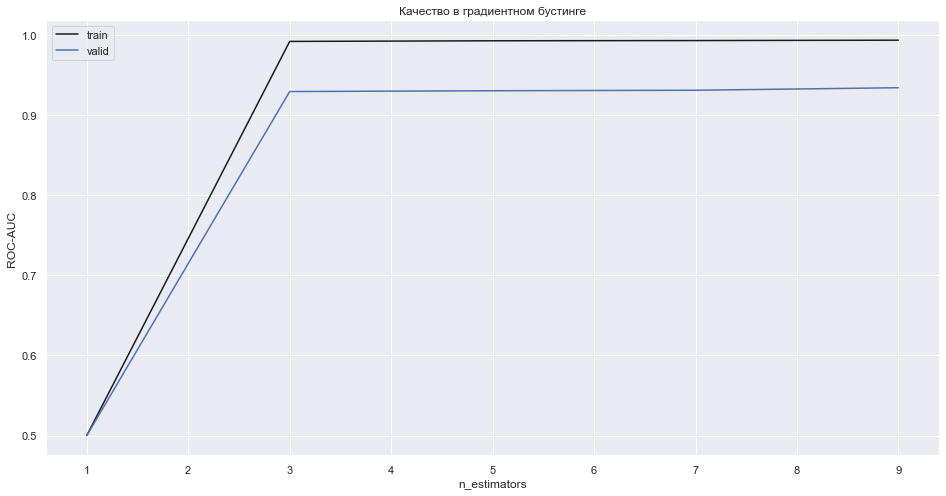

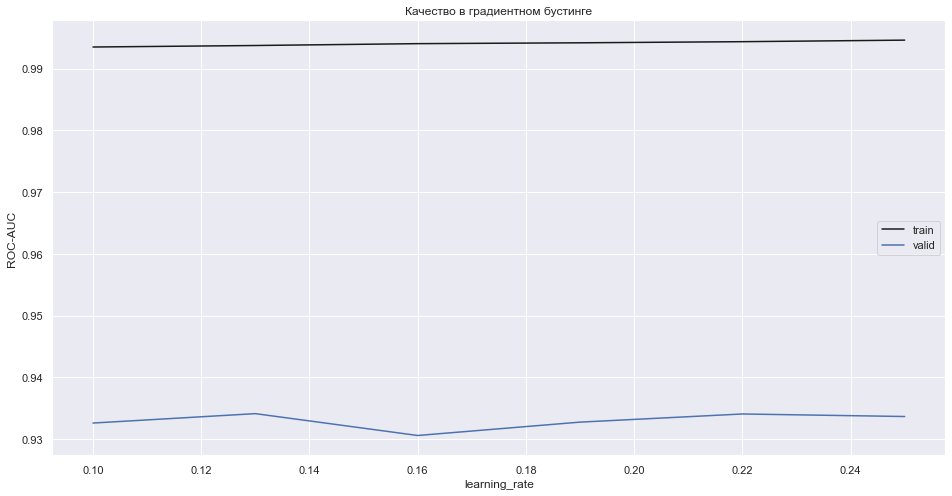

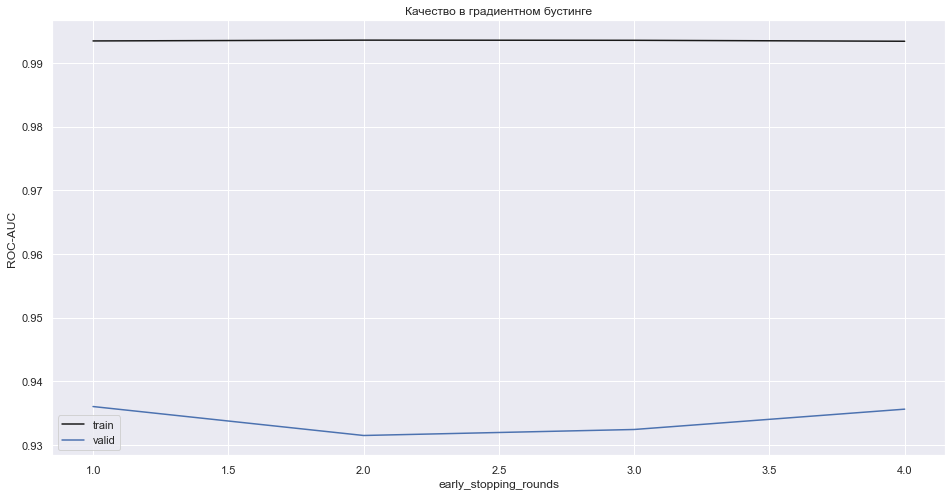

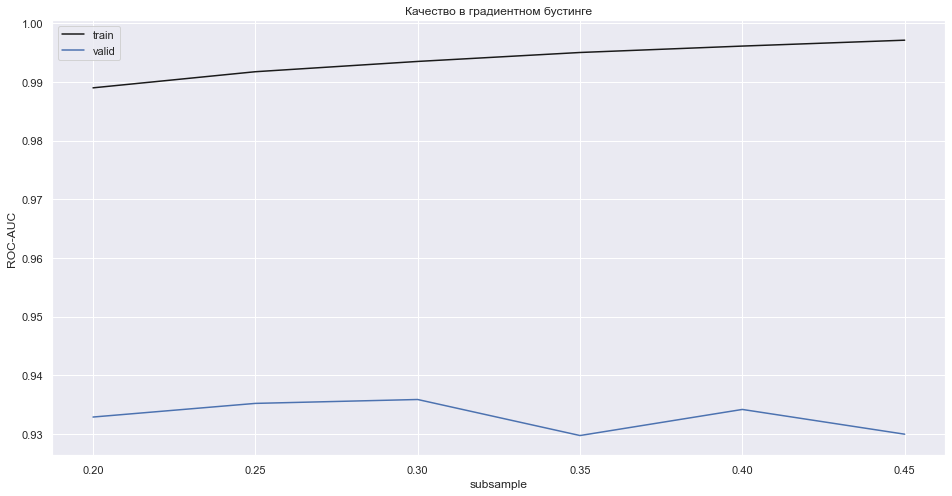

In [71]:
best_hyper['n_estimators'] = choose_boosting(
    x_train, y_train,
    x_valid, y_valid,
    'n_estimators', 1, 10, 2,
)

best_hyper['learning_rate'] = choose_boosting(
    x_train, y_train,
    x_valid, y_valid,
    'learning_rate', 0.1, 0.24, 0.03
)

best_hyper['early_stopping_rounds'] = choose_boosting(
    x_train, y_train,
    x_valid, y_valid,
    'early_stopping_rounds', 1, 5, 1
)

best_hyper['subsample'] = choose_boosting(
    x_train, y_train,
    x_valid, y_valid,
    'subsample', 0.2, 0.4, 0.05
)

plt.show()

In [85]:
def choose_base(
        x_train, y_train,
        x_valid, y_valid,
        name, start, end, ran,
        is_base_model_param=False,
):
    results = {'train': [], 'valid': []}

    for param in np.arange(start, end, ran):
        arguments = {'base_model_params': {name: param}}
        boosting = Boosting(**arguments)
        boosting.fit(x_train, y_train, x_valid, y_valid)
        results['train'].append(boosting.score(x_train, y_train))
        results['valid'].append(boosting.score(x_valid, y_valid))

    plt.figure(figsize=(16, 8))

    plt.plot(np.arange(start, end, ran), results['train'], label='train', c='k')
    plt.plot(np.arange(start, end, ran), results['valid'], label='valid', c='b')

    plt.title('Качество в базовой модели')
    plt.xlabel(name)
    plt.ylabel('ROC-AUC')

    plt.legend()

    best_param = np.arange(start, end, ran)[np.argmax(results['valid'])]
    print('Наилучшее', name, '=', best_param)

    return best_param

Наилучшее min_samples_split = 22
Наилучшее min_samples_leaf = 8


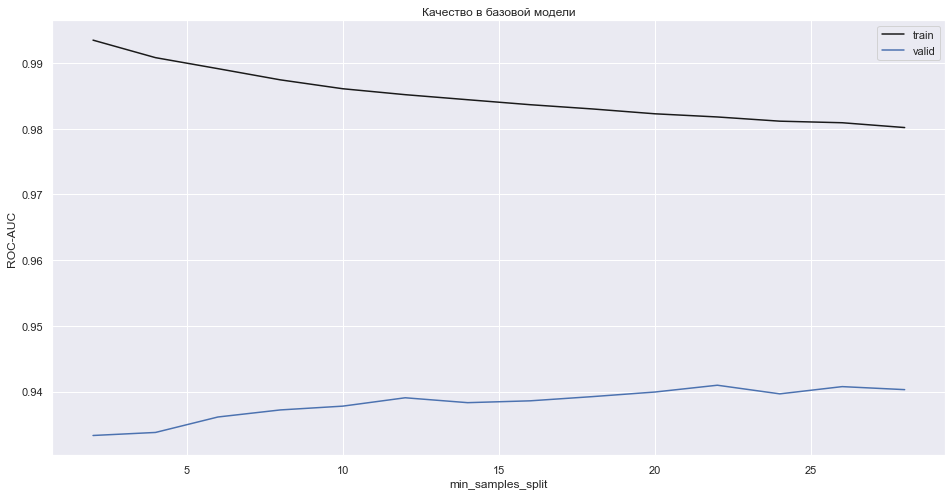

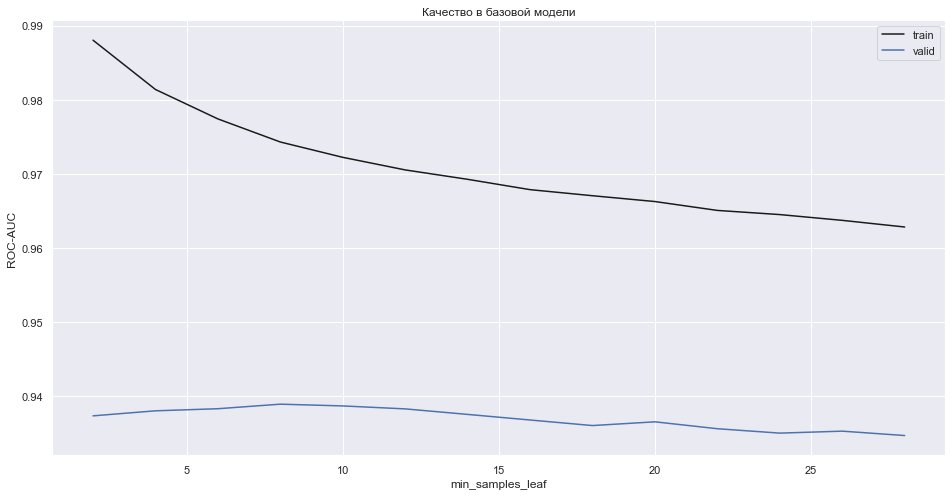

In [86]:
best_hyper['base_model_params']['min_samples_split'] = choose_base(
    x_train, y_train,
    x_valid, y_valid,
    'min_samples_split', 2, 30, 2,
    is_base_model_param=True
)

best_hyper['base_model_params']['min_samples_leaf'] = choose_base(
    x_train, y_train,
    x_valid, y_valid,
    'min_samples_leaf', 2, 30, 2,
    is_base_model_param=True
)

plt.show()

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [108]:
def score_catboost(boosting, x, y):
    return roc_auc_score(y == 1, boosting.predict(x, prediction_type='Probability')[:, 1])

In [111]:
def choose_catboosting(
        x_train, y_train,
        x_valid, y_valid,
        name, start, end, ran,
        is_base_model_param=False,
):
    results = {'train': [], 'test': []}
    
    for param in np.arange(start, end, ran):
        arguments = {name: param}
        boosting = CatBoostRegressor(**arguments, logging_level='Silent')
        boosting.fit(x_train, y_train)

        results['train'].append(score_catboost(boosting, x_train, y_train))
        results['test'].append(score_catboost(boosting, x_test, y_test))

    plt.figure(figsize=(16, 8))

    plt.plot(np.arange(start, end, ran), results['train'], label='train')
    plt.plot(np.arange(start, end, ran), results['test'], label='test')

    plt.title('Качество в Catboost')
    plt.xlabel(name)
    plt.ylabel('ROC-AUC')

    plt.legend()
    plt.show()
    best_param = np.arange(start, end, ran)[np.argmax(results['test'])]
    print('Наилучшее', name, '=', best_param)

best_catboost = {}

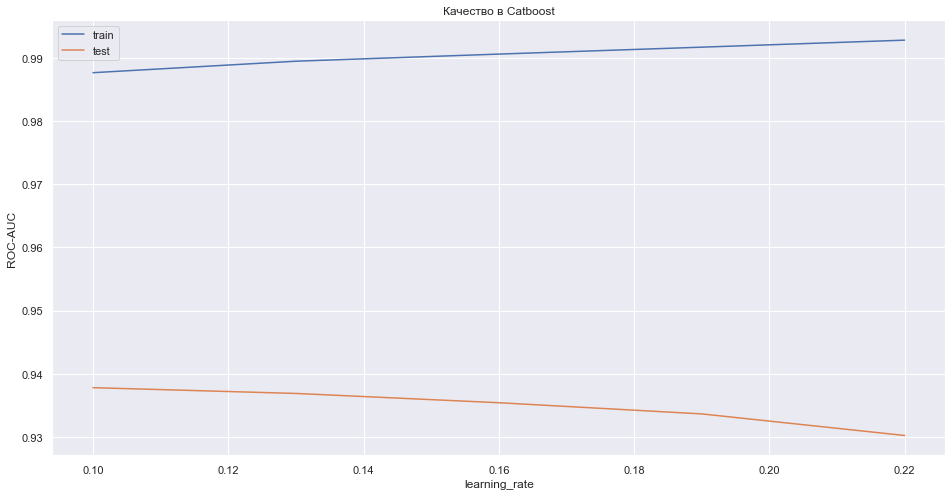

Наилучшее learning_rate = 0.1


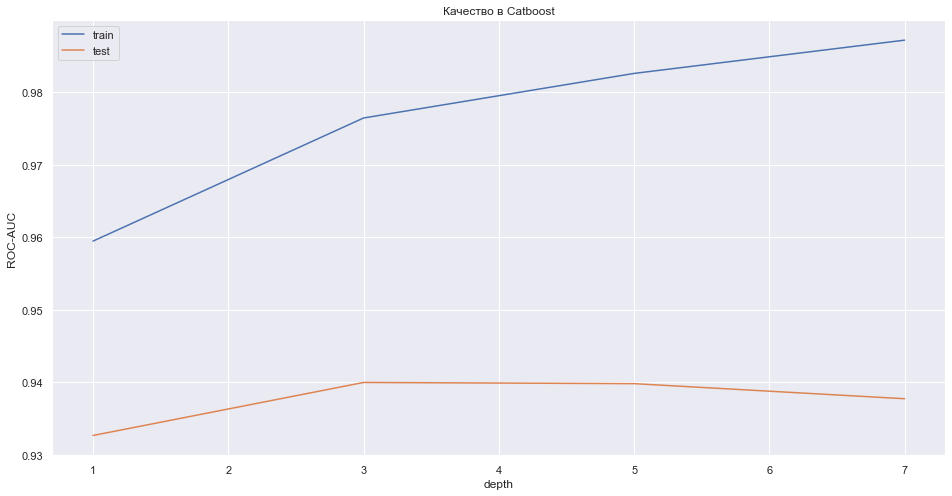

Наилучшее depth = 3


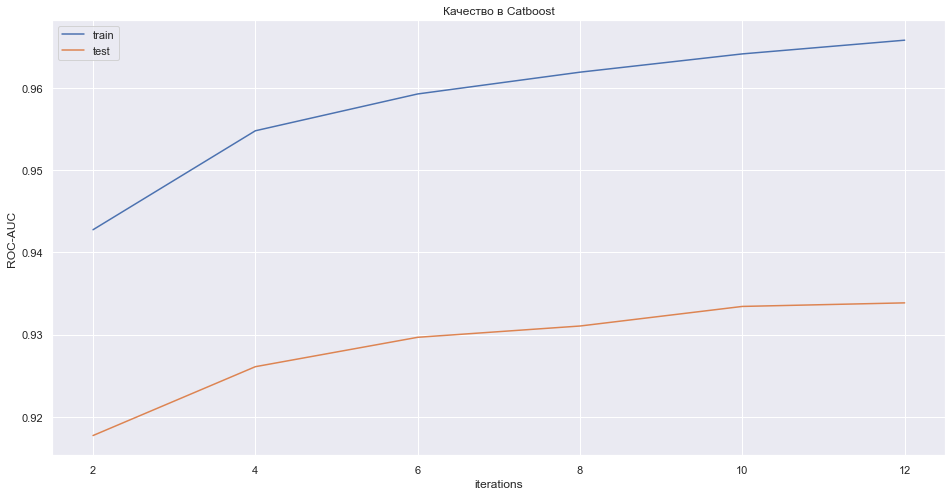

Наилучшее iterations = 12


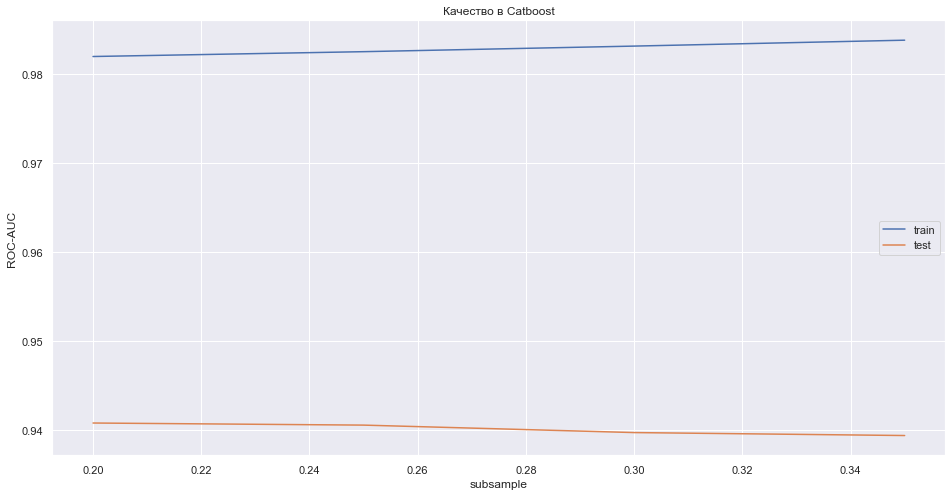

Наилучшее subsample = 0.2


In [127]:
best_catboost['learning_rate'] = choose_catboosting(
    x_train, y_train,
    x_test, y_test,
    'learning_rate', 0.1, 0.24, 0.03
)

best_catboost['depth'] = choose_catboosting(
    x_train, y_train,
    x_test, y_test,
    'depth', 1, 8, 2
)

best_catboost['iterations'] = choose_catboosting(
    x_train, y_train,
    x_test, y_test,
    'iterations', 2, 14, 2
)

best_catboost['subsample'] = choose_catboosting(
    x_train, y_train,
    x_test, y_test,
    'subsample', 0.2, 0.4, 0.05
)

In [114]:
best_boost = Boosting(
    **best_hyper
)

best_cb = CatBoostRegressor(
    **best_catboost,
    logging_level='Silent',
)

In [117]:
best_boost.fit(x_train, y_train, x_valid, y_valid)
best_cb.fit(x_train, y_train)

In [122]:
print('Градиентный бустинг')
print(f'Test AUC-ROC {best_boost.score(x_test, y_test):.4f}')
print(f'Train AUC-ROC {best_boost.score(x_train, y_train):.4f}')

Градиентный бустинг
Test AUC-ROC 0.9355
Train AUC-ROC 0.9737


In [124]:
print('Catboost')
print(f'Test AUC-ROC {score_catboost(best_cb, x_test, y_test):.4f}')
print(f'Train AUC-ROC {score_catboost(best_cb, x_train, y_train):.4f}')

Catboost
Test AUC-ROC 0.9398
Train AUC-ROC 0.9850


### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [ ]:
# YOUR CODE:

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
# YOUR CODE:

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

In [ ]:
# YOUR CODE:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
# YOUR CODE:

## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

In [ ]:
# YOUR CODE:

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2022 года?

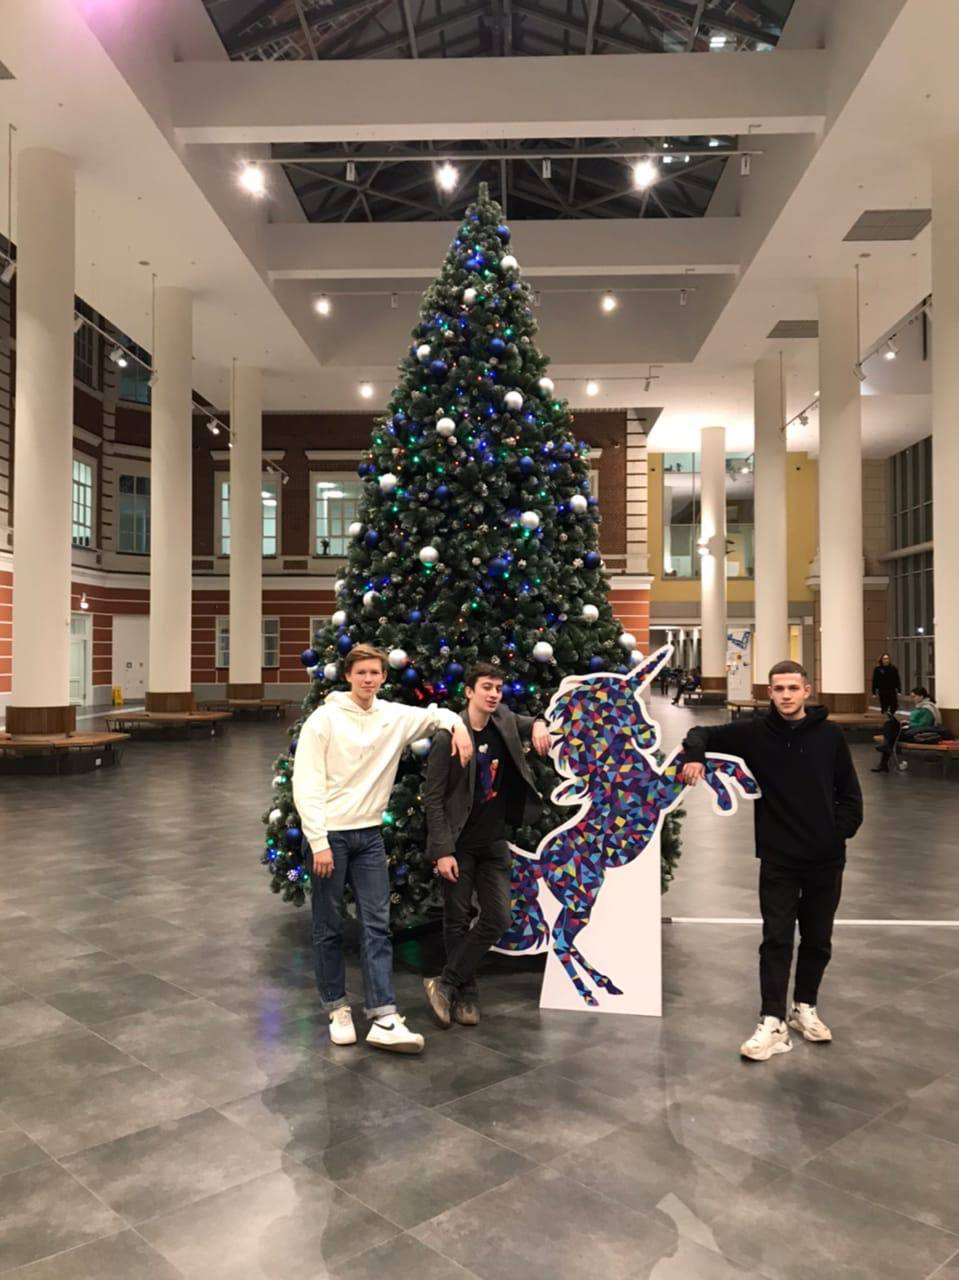

жду успешно сданной сессии, впечатления будут нереальные, с наступающим!